In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from helper import decaying_epsilon, save_obj, load_obj
from helper import evaluate_policy, optimal_agent
from systemrl.environments.gridworld import Gridworld
from systemrl.agents.q_learning import QLearning
from systemrl.agents.sarsa import SARSA
from systemrl.agents.sarsa_lambda import SARSALambda
from systemrl.agents.q_lambda import QLambda
from shared_autonomy import shared_autonomy
from shared_modified import shared_modified
from mincost import mincost
from nqcost import nqcost
from copy import deepcopy
import multiprocessing
%matplotlib inline

In [2]:
def init_random_policy(num_states, num_actions):
    policy = [np.random.choice(num_actions) for i in range(num_states)]
    return policy

def init_nonrandom_policy():
    (u,d,l,r) = (0, 1, 2, 3)
    human_policy = [
            r, r, r, r, d,
            u, d, l, l, l,
            d, l, l, r, d,
            d, r, r, u, d, 
            r, r, u, u, u]
    return human_policy

def init_human_policy():
    (u,d,l,r) = (0, 1, 2, 3)
    human_policy = [
            r, d, r, d, l,
            r, d, r, d, l,
            r, d, l, d, d,
            r, d, d, d, d, 
            r, r, r, r, d]
    return human_policy

In [3]:
np.random.seed(0)
startState=0
endStates=[24]
shape=[5,5]
obstacles=[]
waterStates=np.arange(1,24)
waterRewards=[-1,-1,-1,-5,-9,\
              -3,-4,-1,-6,-5,\
              -1,-1,-1,-2,-6,\
              -1,-8,-4,-5,-7,\
              -1,-1,-1]
env = Gridworld(startState, endStates, shape, obstacles, waterStates, waterRewards, irl_reward=True)

In [4]:
gamma = 1
num_actions = 4
num_states = 25
human_policy = init_nonrandom_policy()#init_random_policy(25, 4)
# human_policy = init_human_policy()
human_performance = np.mean(evaluate_policy(env, human_policy))
print("human performance: ", human_performance)

100%|██████████| 100/100 [00:00<00:00, 3706.07it/s]

evaluating policy
human performance:  -23.372571076201893


In [5]:
saved_model = True

if not saved_model:
    learning_rate = 0.005
    untrained_agent = QLearning(num_actions, gamma, learning_rate)
    trained_agent = optimal_agent(env, untrained_agent, num_episodes=10000)
    q_star = trained_agent.q_table
    save_obj(dict(q_star), "q_star")
else:
    q_star = load_obj("q_star")
J_star = np.max(q_star[startState])
baseline = human_performance
# print(q_star)

In [6]:
# q_table = np.load(file="/home/abhik/696-ds/inverse-rl/gridworld/maxent/results/maxent_q_table.npy") # (400, 3)

In [7]:
# print(q_table)
# q_star = {i: q_table[i] for i in range(len(q_table))}
# J_star = np.max(q_star[0])
# baseline = human_performance
# print(J_star, baseline)

100%|██████████| 38/38 [01:22<00:00,  2.16s/it]


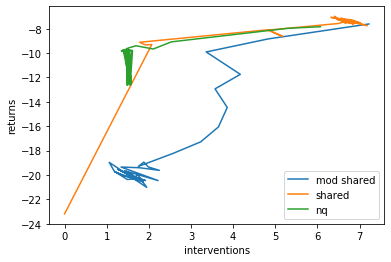

In [8]:
shared = []
nq_cost = []
min_cost = []
mod_shared = []
alphas = np.concatenate((np.arange(0, 1e-3, 1e-4), np.arange(1e-3, 1e-2, 1e-3), np.arange(1e-2, 0.1, 1e-2), np.arange(0.1, 1.01, 0.1)))
# alphas = np.arange(1e-3, 1e-2, 1e-3)
for alpha in tqdm(alphas):
    env.reset()
    min_performance = baseline + alpha * (J_star-baseline)
    #mincost
    """
    untrained_agent = QLambda(num_actions, gamma, learning_rate, 0.5)
    interventions, returns = mincost(env, human_policy, min_performance, untrained_agent, num_episodes=1000)
    """

    #shared autonomy
    interventions, returns = shared_autonomy(env, human_policy, q_star, alpha)
    shared.append((np.mean(interventions), np.mean(returns)))
    
    #modified shared autonomy
    interventions, returns = shared_modified(env, human_policy, q_star, gamma, min_performance)
    mod_shared.append((np.mean(interventions), np.mean(returns)))

    #nqlearning
    lr = 0.09
    interventions, returns = nqcost(env, human_policy, deepcopy(q_star), gamma,\
            lr, min_performance, num_episodes = 1000)
    nq_cost.append((np.mean(interventions),np.mean(returns)))

nq_cost = np.array(nq_cost).T
shared = np.array(shared).T
mod_shared = np.array(mod_shared).T

plt.plot(mod_shared[0], mod_shared[1], label="mod shared")
plt.plot(shared[0], shared[1], label="shared")
plt.plot(nq_cost[0], nq_cost[1], label="nq")
plt.xlabel("interventions")
plt.ylabel("returns")

plt.legend()
plt.savefig("normal_irl")
plt.show()

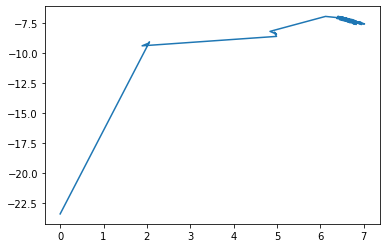

In [8]:
# shared = sorted(shared, key=lambda x: x[1])


plt.plot(shared[0], shared[1])
plt.show()

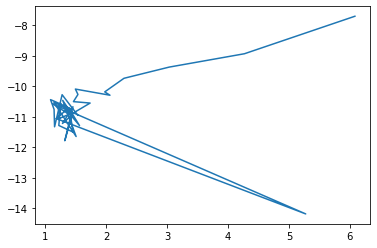

In [9]:
plt.plot(nq_cost[0], nq_cost[1])
plt.show()

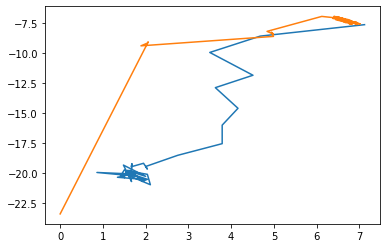

In [10]:
plt.plot(mod_shared[0], mod_shared[1])
plt.plot(shared[0], shared[1])
plt.show()

In [23]:
shared = []
nq_cost = []
min_cost = []
mod_shared = []
c = []
alphas = np.concatenate((np.arange(0, 1e-3, 1e-4), np.arange(1e-3, 1e-2, 1e-3), np.arange(1e-2, 0.1, 1e-2), np.arange(0.1, 1.01, 0.1)))
# alphas = np.arange(1e-3, 1e-2, 1e-3)
for alpha in tqdm(alphas):
    env.reset()
    min_performance = baseline + alpha * (J_star-baseline)
    #mincost
    """
    untrained_agent = QLambda(num_actions, gamma, learning_rate, 0.5)
    interventions, returns = mincost(env, human_policy, min_performance, untrained_agent, num_episodes=1000)
    """

#     #shared autonomy
#     interventions, returns = shared_autonomy(env, human_policy, q_star, alpha)
#     shared.append((np.mean(interventions), np.min(returns)))
    
#     #modified shared autonomy
#     interventions, returns = shared_modified(env, human_policy, q_star, gamma, min_performance)
#     mod_shared.append((np.mean(interventions), np.min(returns)))

    #nqlearning
    for lr in np.arange(0, 1e-2, 1e-3):
        print(lr)
        interventions, returns = nqcost(env, human_policy, deepcopy(q_star), gamma,\
                lr, min_performance, num_episodes = 1000)
        nq_cost.append((np.mean(interventions),np.min(returns)))
        
    c.append(nq_cost)

# nq_cost = np.array(nq_cost).T
# shared = np.array(shared).T
# mod_shared = np.array(mod_shared).T
c = np.array(c).T

# plt.plot(mod_shared[0], mod_shared[1], label="mod shared")
# plt.plot(shared[0], shared[1], label="shared")
plt.plot(c[0], c[1], label="nq")
plt.xlabel("interventions")
plt.ylabel("returns")

plt.legend()
plt.savefig("normal_irl")
plt.show()

  0%|          | 0/38 [00:00<?, ?it/s]

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001


  3%|▎         | 1/38 [00:20<12:22, 20.07s/it]

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001


  5%|▌         | 2/38 [00:42<12:23, 20.66s/it]

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001


  8%|▊         | 3/38 [01:03<12:05, 20.74s/it]

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001


 11%|█         | 4/38 [01:24<11:57, 21.10s/it]

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001


 13%|█▎        | 5/38 [01:50<12:18, 22.39s/it]

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001


 16%|█▌        | 6/38 [02:13<12:06, 22.72s/it]

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001


 18%|█▊        | 7/38 [02:38<12:00, 23.25s/it]

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001


 21%|██        | 8/38 [03:00<11:26, 22.88s/it]

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001


 24%|██▎       | 9/38 [03:23<11:03, 22.89s/it]

0.0
0.001
0.002
0.003
0.004
0.005
0.006


KeyboardInterrupt: 

In [22]:
for lr in np.arange(0, 1e-2, 1e-3):
    print(lr)

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
